# Course 6 - Time Series and Survival Analysis

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
os.chdir('data')
from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
sns.set_palette(palette)
import pandas as pd
from datetime import datetime
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Dataset from by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) that measures hourly air quality in Chinese cities/city districts

In [2]:
df = pd.read_csv('./FiveCitiesPM/Shanghai.csv')
df.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,0.0,0.0


In [12]:
df.isnull().sum()

No                   0
year                 0
month                0
day                  0
hour                 0
season               0
PM_Jingan        27884
PM_US Post       18545
PM_Xuhui         27395
DEWP                13
HUMI                13
PRES                28
TEMP                13
cbwd                12
Iws                 12
precipitation     4009
Iprec             4009
dtype: int64

In [16]:
df.describe()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
count,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,24700.000000,34039.000000,25189.000000,52571.000000,52571.000000,52556.000000,52571.000000,52572.000000,48575.000000,48575.000000
mean,26292.500000,2012.499772,6.523962,15.726609,11.500000,2.491100,57.395992,52.910544,57.678987,11.295372,69.545646,1016.017564,17.471115,49.602367,0.142001,0.935362
std,15179.837614,1.707485,3.448452,8.798896,6.922252,1.116988,47.616179,42.576138,48.412620,9.877649,17.658942,9.016829,9.315528,78.283572,1.065094,6.586855
min,1.000000,2010.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-21.000000,11.320000,990.000000,-5.000000,0.000000,0.000000,0.000000
25%,13146.750000,2011.000000,4.000000,8.000000,5.750000,1.000000,26.000000,26.000000,26.000000,3.000000,57.930000,1008.100000,10.000000,6.000000,0.000000,0.000000
50%,26292.500000,2012.000000,7.000000,16.000000,11.500000,2.000000,44.000000,41.000000,43.000000,12.000000,72.420000,1016.000000,18.000000,20.000000,0.000000,0.000000
75%,39438.250000,2014.000000,10.000000,23.000000,17.250000,3.000000,73.000000,67.000000,73.000000,20.000000,83.370000,1023.000000,25.000000,61.000000,0.000000,0.000000
max,52584.000000,2015.000000,12.000000,31.000000,23.000000,4.000000,635.000000,730.000000,636.000000,28.000000,100.000000,1040.000000,41.000000,1110.000000,61.600000,226.400000


In [23]:
print(df['season'].unique())
print(df['year'].unique())
print(df['cbwd'].unique())

[4 1 2 3]
[2010 2011 2012 2013 2014 2015]
['cv' 'SE' 'SW' nan 'NW' 'NE']


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
No               52584 non-null int64
year             52584 non-null int64
month            52584 non-null int64
day              52584 non-null int64
hour             52584 non-null int64
season           52584 non-null int64
PM_Jingan        24700 non-null float64
PM_US Post       34039 non-null float64
PM_Xuhui         25189 non-null float64
DEWP             52571 non-null float64
HUMI             52571 non-null float64
PRES             52556 non-null float64
TEMP             52571 non-null float64
cbwd             52572 non-null object
Iws              52572 non-null float64
precipitation    48575 non-null float64
Iprec            48575 non-null float64
dtypes: float64(10), int64(6), object(1)
memory usage: 6.8+ MB


We are interested in attempting to forecast the 'PM' series (PM_Jingan, PM_US Post, PM_Xuhui), which are measurements of air pollution for several different districts. There are many missing values in these series, which can be filled with simple linear interpolation.

- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- season: season of data in this row
- PM: PM2.5 concentration (ug/m^3)
- DEWP: Dew Point (Celsius Degree)
- TEMP: Temperature (Celsius Degree)
- HUMI: Humidity (%)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- precipitation: hourly precipitation (mm)
- Iprec: Cumulated precipitation (mm)

In [3]:
# interpolating missing values for PM
# only values inbetween two other values will be filled
# Since all the values are not available, only a portion of the dataset will be used (year 2013 - 2014)

df['PM_Jingan'] = df['PM_Jingan'].interpolate() 
df['PM_US Post'] = df['PM_US Post'].interpolate() 
df['PM_Xuhui'] = df['PM_Xuhui'].interpolate() 

df = df[df.year >= 2013]
df = df[df.year <= 2014]

df.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
26304,26305,2013,1,1,0,4,66.0,70.0,71.0,-5.0,69.00,1023.0,0.0,SW,60.0,0.0,0.0
26305,26306,2013,1,1,1,4,67.0,76.0,72.0,-5.0,69.00,1023.0,0.0,SW,62.0,0.0,0.0
26306,26307,2013,1,1,2,4,70.0,72.0,73.0,-5.0,69.00,1023.0,0.0,SW,63.0,0.0,0.0
26307,26308,2013,1,1,3,4,73.0,78.0,74.0,-4.0,74.41,1023.0,0.0,SW,65.0,0.0,0.0
26308,26309,2013,1,1,4,4,75.0,77.0,77.0,-4.0,80.04,1023.0,-1.0,SW,68.0,0.0,0.0


In [70]:
df.tail()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,date
date,,,,,,,,,,,,,,,,,,
2014-12-31 19:00:00,43820,2014,12,31,19,4,72.0,84.0,75.0,-5.0,48.34,1031.0,5.0,NW,107.0,0.0,0.0,2014-12-31 19:00:00
2014-12-31 20:00:00,43821,2014,12,31,20,4,70.0,71.0,75.0,-6.0,48.04,1031.0,4.0,NE,5.0,0.0,0.0,2014-12-31 20:00:00
2014-12-31 21:00:00,43822,2014,12,31,21,4,53.0,42.0,58.0,-9.0,38.08,1031.0,4.0,NW,8.0,0.0,0.0,2014-12-31 21:00:00
2014-12-31 22:00:00,43823,2014,12,31,22,4,38.0,37.0,40.0,-9.0,40.86,1032.0,3.0,NE,5.0,0.0,0.0,2014-12-31 22:00:00
2014-12-31 23:00:00,43824,2014,12,31,23,4,25.0,32.0,32.0,-12.0,34.56,1033.0,2.0,NW,6.0,0.0,0.0,2014-12-31 23:00:00


In [4]:
# making datetime column 

# df.apply(): apply a function across an axis of the df

def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])

df['date'] = df.apply(make_date,axis=1)
df.set_index(df.date, inplace=True)
df.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,date
date,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,26305,2013,1,1,0,4,66.0,70.0,71.0,-5.0,69.00,1023.0,0.0,SW,60.0,0.0,0.0,2013-01-01 00:00:00
2013-01-01 01:00:00,26306,2013,1,1,1,4,67.0,76.0,72.0,-5.0,69.00,1023.0,0.0,SW,62.0,0.0,0.0,2013-01-01 01:00:00
2013-01-01 02:00:00,26307,2013,1,1,2,4,70.0,72.0,73.0,-5.0,69.00,1023.0,0.0,SW,63.0,0.0,0.0,2013-01-01 02:00:00
2013-01-01 03:00:00,26308,2013,1,1,3,4,73.0,78.0,74.0,-4.0,74.41,1023.0,0.0,SW,65.0,0.0,0.0,2013-01-01 03:00:00
2013-01-01 04:00:00,26309,2013,1,1,4,4,75.0,77.0,77.0,-4.0,80.04,1023.0,-1.0,SW,68.0,0.0,0.0,2013-01-01 04:00:00


In [5]:
data1 = df.filter(['PM_Jingan'], axis=1)
data2 = df.filter(['PM_US Post'], axis=1)
data3 = df.filter(['PM_Xuhui'], axis=1)

data1.head()

,PM_Jingan
date,
2013-01-01 00:00:00,66.0
2013-01-01 01:00:00,67.0
2013-01-01 02:00:00,70.0
2013-01-01 03:00:00,73.0
2013-01-01 04:00:00,75.0


### Data1 (Jingan)

- Visualtizing the data

In [6]:
import statsmodels.api as sm
import pmdarima as pm

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook

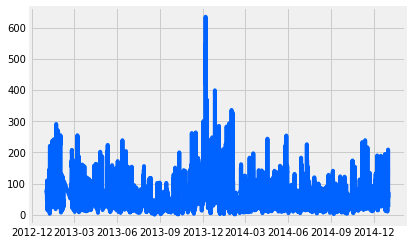

In [74]:
plt.plot(data1)

In [126]:
# fig = plt.figure(figsize = (12,12))

# for n in range(12): 
#     plt.subplot(3, 4, n+1)
    
#     start = (24*30)*(n)
#     end = (24*30)*(n + 1) +1
    
#     plt.title('Month {}'.format(n+1))
#     plt.plot(data1[start:][:end] )

In [120]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data1['PM_Jingan'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -12.679692128030313
p-value: 1.1944289413633343e-23


p-value < 0.05 means we could reject Ho: series is non-stationary

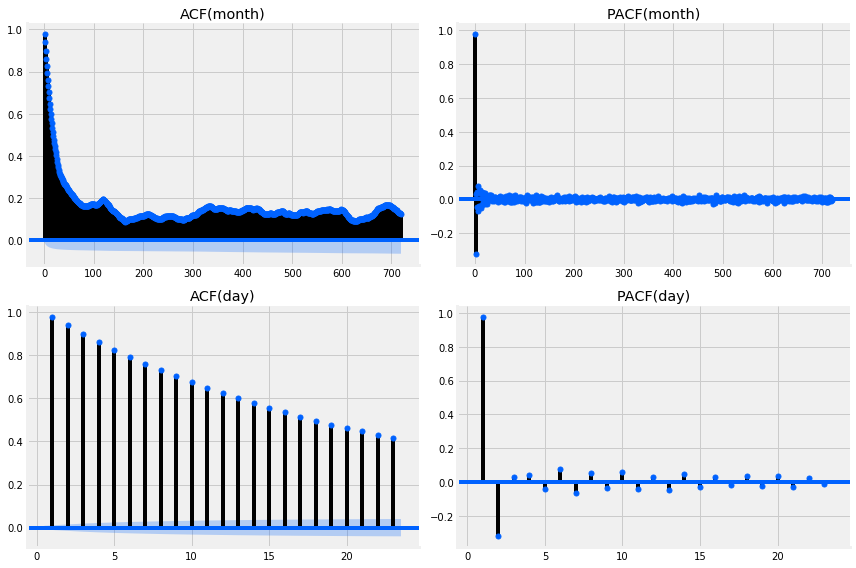

In [86]:
# ACF and PACF plots for the past one day and 1 month
plt.figure(figsize = (12,8))
layout = (2, 2)
acfM  = plt.subplot2grid(layout, (0, 0))
pacfM = plt.subplot2grid(layout, (0, 1))
acfD  = plt.subplot2grid(layout, (1, 0))
pacfD = plt.subplot2grid(layout, (1, 1))  

# one month
sm.tsa.graphics.plot_acf(data1, lags=range(1,24*30),ax = acfM, alpha=0.25,title = 'ACF(month)')
sm.tsa.graphics.plot_pacf(data1, lags=range(1,24*30), ax = pacfM, alpha=0.25,title = 'PACF(month)')
         
# one day
sm.tsa.graphics.plot_acf(data1, lags=range(1,24), ax = acfD, alpha=0.25,title = 'ACF(day)')
sm.tsa.graphics.plot_pacf(data1, lags=range(1,24), ax = pacfD, alpha=0.25,title = 'PACF(day)')

sns.despine()
plt.tight_layout()

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

There is an exponential decay in the ACF plot (not exctly to zero though, to <0.2) with lag 1 and 2 in PACF having significantly large values (>0.1). There is also a alternating pattern in the PACF. 

- This suggets that the model has an AR(2) component.

- The model could be an ARIMA because the series is non-stationary.


## Time Series Analysis 
- ARIMA
- RNN
- LSTM

In [7]:
# 23 months, Jan 2013 - Nov 2014, 16776 values
train = data1.iloc[0:-24*31 ,:]
# 24th month, Dec 2014, 744 values
test = data1.iloc[-24*31:,:]

### ARIMA

In [134]:
# d(differencing) = 0
stepwise_model = pm.auto_arima(train['PM_Jingan'], start_p=0, start_q=0,
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0); AIC=178790.629, BIC=178806.084, Fit time=0.539 seconds
Fit ARIMA: order=(1, 0, 0); AIC=126824.556, BIC=126847.739, Fit time=0.929 seconds
Fit ARIMA: order=(0, 0, 1); AIC=159950.704, BIC=159973.887, Fit time=1.433 seconds
Fit ARIMA: order=(2, 0, 0); AIC=125054.895, BIC=125085.806, Fit time=0.354 seconds
Fit ARIMA: order=(2, 0, 1); AIC=125047.472, BIC=125086.111, Fit time=5.054 seconds
Fit ARIMA: order=(1, 0, 1); AIC=125196.309, BIC=125227.219, Fit time=2.366 seconds
Fit ARIMA: order=(2, 0, 2); AIC=124453.696, BIC=124500.063, Fit time=6.809 seconds
Fit ARIMA: order=(1, 0, 2); AIC=125006.070, BIC=125044.709, Fit time=2.327 seconds
Total fit time: 20.027 seconds
124453.69629207299


ARIMA(2,0,2) = ARMA(2,2) was the best fit (lowest AIC)

In [135]:
# d = 1
stepwise_model = pm.auto_arima(train['PM_Jingan'], start_p=0, start_q=0,
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 1, 0); AIC=127005.483, BIC=127020.938, Fit time=0.110 seconds
Fit ARIMA: order=(1, 1, 0); AIC=125408.155, BIC=125431.338, Fit time=0.156 seconds
Fit ARIMA: order=(0, 1, 1); AIC=125474.169, BIC=125497.352, Fit time=0.111 seconds
Fit ARIMA: order=(2, 1, 0); AIC=125371.705, BIC=125402.615, Fit time=0.162 seconds
Fit ARIMA: order=(2, 1, 1); AIC=125013.653, BIC=125052.291, Fit time=5.451 seconds
Fit ARIMA: order=(1, 1, 1); AIC=125383.509, BIC=125414.420, Fit time=2.502 seconds
Fit ARIMA: order=(2, 1, 2); AIC=124750.432, BIC=124796.798, Fit time=6.361 seconds
Fit ARIMA: order=(1, 1, 2); AIC=124752.605, BIC=124791.243, Fit time=5.733 seconds
Total fit time: 20.871 seconds
124750.43245588645


ARIMA(2,1,2) was the best fit, although AIC is higher than ARMA(2,2)

In [209]:
# ARIMA(2,0,2)

arima = sm.tsa.statespace.SARIMAX(train['PM_Jingan'], 
                                order=(2,0,2), 
                                seasonal_order=(0,0,0,12), 
                                trend='n').fit()

# arima = arima.fit()
arima.summary()

C:\Users\sarth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              PM_Jingan   No. Observations:                16776
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -62311.049
Date:                Wed, 06 Oct 2021   AIC                         124632.097
Time:                        22:10:57   BIC                         124670.736
Sample:                    01-01-2013   HQIC                        124644.847
                         - 11-30-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0092      0.002      4.017      0.000       0.005       0.014
ar.L2          0.9598      0.002    424.393      0.000       0.955       0.964
ma.L1          1.3237      0.003    387.436      0.000       1.317       1.330
ma.L2          0.3725      0.003    134.183      0.000       0.367       0.378
sigma2        98.5377      0.304    324.596      0.000      97.943      99.133
===================================================================================
Ljung-Box (Q):                      165.28   Jarque-Bera (JB):            413044.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

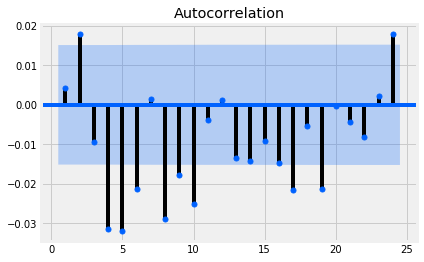

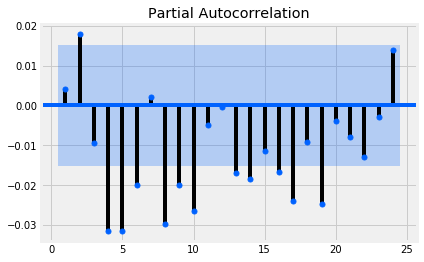

In [143]:
# plot resids
fig = sm.tsa.graphics.plot_acf(arima.resid[arima.loglikelihood_burn:], lags=24,  zero=False)
fig = sm.tsa.graphics.plot_pacf(arima.resid[arima.loglikelihood_burn:], lags=24,  zero = False)

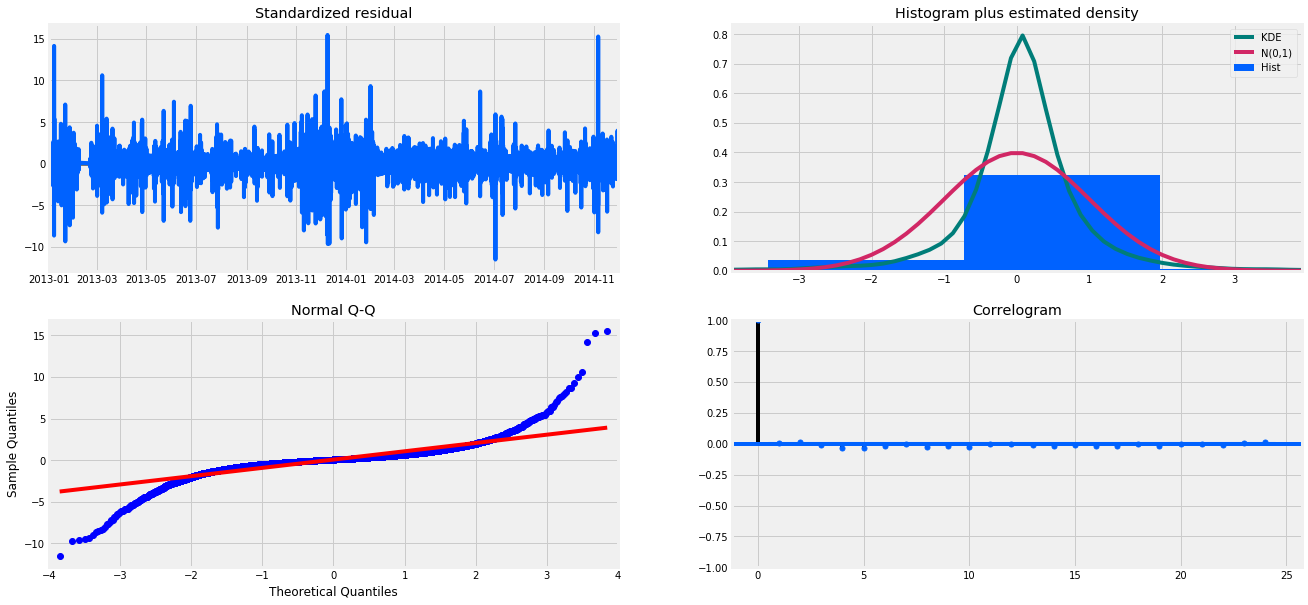

In [144]:
# plot residual diagnostics
arima.plot_diagnostics(lags=24,figsize = (20,10),);

In [225]:
# plot predictions
pd.plotting.register_matplotlib_converters()
Predict = pd.DataFrame()
#use model.predict() start and end in relation to series
Predict['ARMA'] = arima.predict(start = 16056, end= (16775) )   # predicting Nov 2014

In [226]:
Predict['Actual'] = train.iloc[16056:16776,:]
Predict.tail()

# Predict.isnull().sum()
# Predict.describe()

,ARMA,Actual
2014-11-30 19:00:00,15.764582,19.0
2014-11-30 20:00:00,19.870349,32.0
2014-11-30 21:00:00,35.790689,41.0
2014-11-30 22:00:00,42.503261,43.0
2014-11-30 23:00:00,42.343858,53.0


129.9797869595771


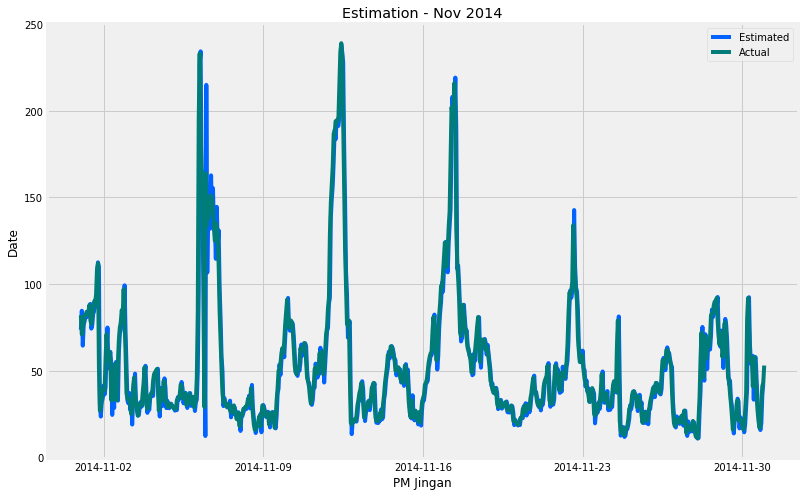

In [227]:
plt.figure(figsize=(12,8))

plt.plot(Predict['ARMA'], label= 'Estimated')
plt.plot(Predict['Actual'], label='Actual')
plt.legend()
plt.title('Estimation - Nov 2014')
plt.xlabel('PM Jingan')
plt.ylabel('Date')

print(mean_squared_error(Predict['Actual'], Predict['ARMA']))

6858.143012484323


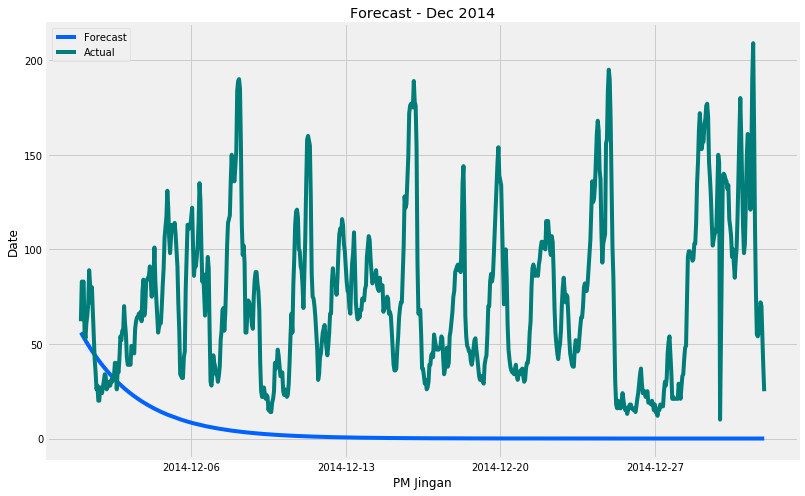

In [223]:
# plot predictions for future unseen values
pd.plotting.register_matplotlib_converters()
Forecast = pd.DataFrame()
#use model.predict() start and end in relation to series
Forecast['ARMA'] = arima.predict(start = 16776, end= (16776+743) )   # predicting Dec 2014
Forecast['Actual'] = test
Forecast.tail()

plt.figure(figsize=(12,8))

plt.plot(Forecast['ARMA'], label= 'Forecast')
plt.plot(Forecast['Actual'], label='Actual')
plt.legend()
plt.title('Forecast - Dec 2014')
plt.xlabel('PM Jingan')
plt.ylabel('Date')

print(mean_squared_error(Forecast['Actual'], Forecast['ARMA']))

### RNN

Using n hr of past PM data to estimate n+1 hr of PM values. 

Repeat after skipping every next k data points. 

eg. 1:n -> n+1, 1+k:n+k -> n+1+k, ...

In [63]:
# scaling down to 0-1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range= (0,1))

data_scale = sc.fit_transform(data1)

train = data_scale[0:-24*31]
test = data_scale[-24*31:]

train.shape, test.shape

((16776, 1), (744, 1))

In [75]:
train_X, train_y = [], []

sample_gap = 3 #k
input_hours = 6 #n

for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

train_X = np.array(train_X)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1) # format our new training set to keras format
train_y = np.array(train_y) # make sure y is an array to work properly with keras

# The set that we had held out for testing (must be same length as original train input)
test_X = test[:input_hours] 
test_y = test[input_hours:] # test_y is remaining values from test set

In [76]:
print(train_X.shape, test_X.shape,train_y.shape, test_y.shape)

(5590, 6, 1) (6, 1) (5590, 1) (738, 1)


In [85]:
# RNN

model = Sequential() 
model.add(SimpleRNN(90, activation='relu',input_shape=(train_X.shape[1],1), return_sequences = True))
# model.add(Dropout(0.2))
model.add(SimpleRNN(120, activation='relu', return_sequences = True))
# model.add(Dropout(0.2))
# model.add(SimpleRNN(90, activation='tanh', return_sequences = True))
model.add(SimpleRNN(30, activation='relu', return_sequences = False))
# model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(12))
# model.add(SimpleRNN(, activation='relu', use_bias=True))

# output layer to make final predictions 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_38 (SimpleRNN)    (None, 6, 90)             8280      
_________________________________________________________________
simple_rnn_39 (SimpleRNN)    (None, 6, 120)            25320     
_________________________________________________________________
simple_rnn_40 (SimpleRNN)    (None, 30)                4530      
_________________________________________________________________
dense_19 (Dense)             (None, 12)                372       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 13        
Total params: 38,515
Trainable params: 38,515
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.fit(train_X, train_y, epochs=100, batch_size = 50,verbose=0)

6770.016675219812


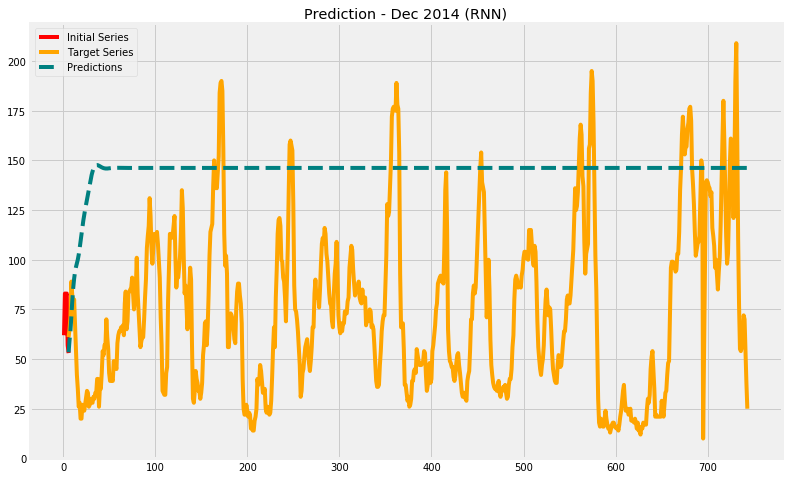

In [96]:
test_hours = len(test_y) 

test_X_init = test_X

def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first n values with 2nd through nth
        X_init[:,-1,:] = pred # replace nth value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds


y_preds = predict(test_X_init, n_steps=len(test_y), model=model)

# Below ranges are to set x-axes
start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
predict_range = range(test_X_init.shape[0], test_hours + test_X_init.shape[0])  #predict range is going to be from end of X_init to length of test_hours


test_y.shape, y_preds.shape, test_X_init.shape

plt.figure(figsize=(12,8))
#using our ranges we plot X_init
plt.plot(start_range, sc.inverse_transform(test_X_init), color = 'red')
#and test and actual preds
plt.plot(predict_range, sc.inverse_transform(test_y), color='orange')
plt.plot(predict_range, sc.inverse_transform(y_preds), color='teal', linestyle='--')

plt.title('Prediction - Dec 2014 (RNN)')
plt.legend(['Initial Series','Target Series','Predictions'])


print(mean_squared_error(sc.inverse_transform(test_y), sc.inverse_transform(y_preds)))

### LSTM

In [102]:
model2 = Sequential() 
model2.add(LSTM(90, activation='relu', input_shape=(train_X.shape[1],1),return_sequences= True))
model2.add(LSTM(120, activation='relu', return_sequences = True))
model2.add(LSTM(30, activation='relu', return_sequences = False))
model2.add(Dense(12))
model2.add(Dense(1))

# output layer to make final predictions 
model.add(Dense(1))


model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 6, 90)             33120     
_________________________________________________________________
lstm_8 (LSTM)                (None, 6, 120)            101280    
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                18120     
_________________________________________________________________
dense_27 (Dense)             (None, 12)                372       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 13        
Total params: 152,905
Trainable params: 152,905
Non-trainable params: 0
_________________________________________________________________


In [103]:
model2.fit(train_X, train_y, epochs=100, batch_size=50, verbose=0)

4900.1486271795275


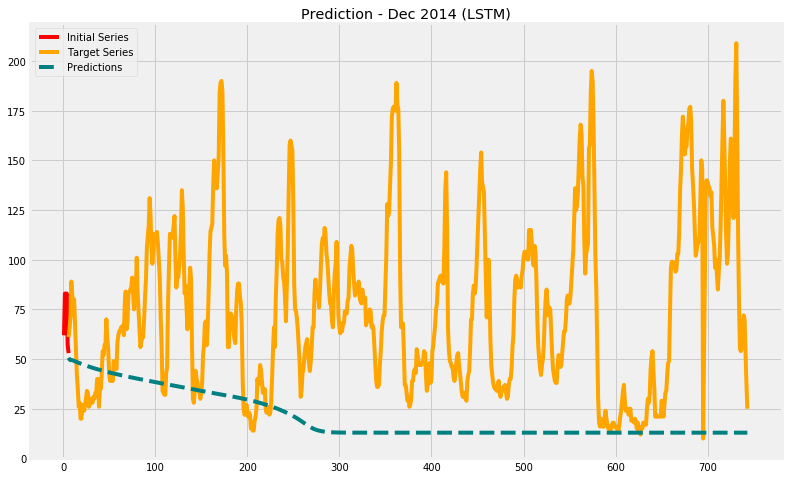

In [104]:
test_hours = len(test_y) 

test_X_init = test_X

def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first n values with 2nd through nth
        X_init[:,-1,:] = pred # replace nth value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds


y_preds = predict(test_X_init, n_steps=len(test_y), model=model2)

# Below ranges are to set x-axes
start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
predict_range = range(test_X_init.shape[0], test_hours + test_X_init.shape[0])  #predict range is going to be from end of X_init to length of test_hours


test_y.shape, y_preds.shape, test_X_init.shape

plt.figure(figsize=(12,8))
#using our ranges we plot X_init
plt.plot(start_range, sc.inverse_transform(test_X_init), color = 'red')
#and test and actual preds
plt.plot(predict_range, sc.inverse_transform(test_y), color='orange')
plt.plot(predict_range, sc.inverse_transform(y_preds), color='teal', linestyle='--')

plt.title('Prediction - Dec 2014 (LSTM)')
plt.legend(['Initial Series','Target Series','Predictions'])

print(mean_squared_error(sc.inverse_transform(test_y), sc.inverse_transform(y_preds)))